### Preprocessing con sostituzione dei valori nan

In [167]:
import pandas as pd
import numpy as np
import matplotlib as plt

In [168]:
# URL completi dei file nel repository GitHub
thca_url = '../data/dsthca_genesremoved.csv'
lusc_url = '../data/dslusc_genesremoved.csv'
skcm_url = '../data/dsskcm_genesremoved.csv'
coadread_url = '../data/dsco_genesremoved.csv'

In [169]:
ds_thca = pd.read_csv(thca_url)

In [170]:
ds_lusc = pd.read_csv(lusc_url)

In [171]:
ds_skcm =  pd.read_csv(skcm_url)

In [172]:
ds_coadread =  pd.read_csv(coadread_url)

### Preparing

In [173]:
'''def prepareData(df):
    #genes = df['Entrez_Gene_Id']
    df = df.drop(columns=['Entrez_Gene_Id'])

    return df'''

"def prepareData(df):\n    #genes = df['Entrez_Gene_Id']\n    df = df.drop(columns=['Entrez_Gene_Id'])\n\n    return df"

### Outliers detection

#### LocalOutlierFactor

In [174]:
from sklearn.neighbors import LocalOutlierFactor

In [175]:
def detect_outliers_localOut_factor(data, k):

    lof = LocalOutlierFactor(n_neighbors=k, metric='euclidean', n_jobs=7)
    outliers_lof = lof.fit_predict(data) 
    
    print(f"{k} - Sono stati trovati {len(outliers_lof[outliers_lof == -1])} outliers")
    
    return outliers_lof

#for i in range(1, 100, 3):
#for i in range(150, 500, 10):
    #detect_outliers_localOut_factor(df, i)


# Con k 1 a 50 trova sempre 116 outliers se settiamo contamination = 0.0112 sull'intero dataset
    # ho provato anche valori più grandi (500, 1000, 1500) ma resta sempre 116 
# Con k 1 a 50 il numero cambia se lasciamo contamination settato di default. In questo caso i valori sono crescenti per k>=5 (a parte eccezioni come k= 31 e k=33).
#   in questo caso k = 30 potrebbe essere ok? (con k=31: 406 outliers; con k=21: 344)

# n_jobs aumenta la velocità (non di molto almeno sul mio pc, si può anche rimuovere)
# metric -> euclidean

# per quanto riguarda contamination forse in questo caso è meglio settarla a 'auto'?
# Dalla documentazione:
    #contamination ‘auto’ or float, default=’auto’
    #The amount of contamination of the data set, i.e. the proportion of outliers in the data set. 
    #When fitting this is used to define the threshold on the scores of the samples.
    
    #if ‘auto’, the threshold is determined as in the original paper,
    #if a float, the contamination should be in the range (0, 0.5].
    
    # ==> Changed in version 0.22: The default value of contamination changed from 0.1 to 'auto'.

#### Prova

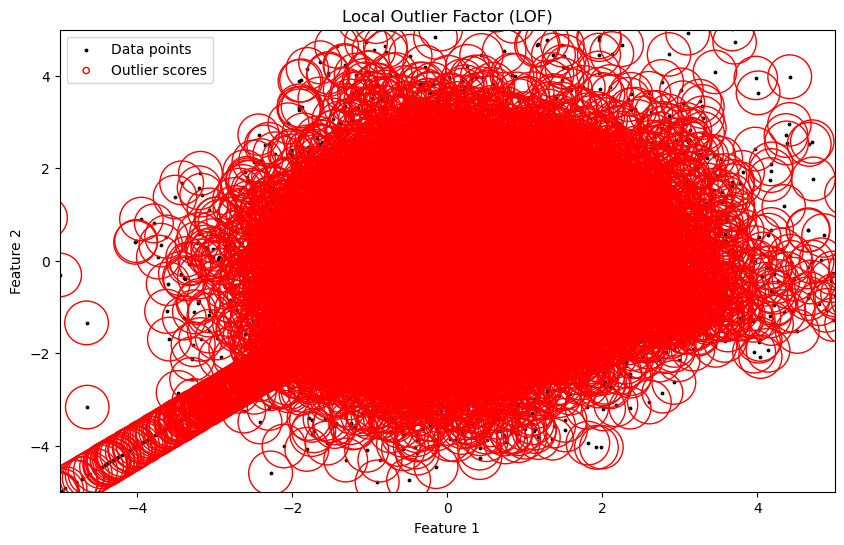

In [176]:
################################### PROVA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from matplotlib.legend_handler import HandlerPathCollection

def update_legend_marker_size(handle, orig):
    """Customize size of the legend marker"""
    handle.update_from(orig)
    handle.set_sizes([20])

# Assuming df is your DataFrame and the Local Outlier Factor has been applied
def plot_lof_outliers(df, n_neighbors):
    # Apply LOF
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination='auto')
    lof_fit = lof.fit(df)
    X_scores = -lof.negative_outlier_factor_
    outliers = lof_fit.fit_predict(df)
    #df_filtered = df[outliers == 1]
    #X = df_filtered.to_numpy()

    plt.figure(figsize=(10, 6))
    plt.scatter(df.iloc[:, 0], df.iloc[:, 1], color="k", s=3.0, label="Data points")
    
    # plot circles with radius proportional to the outlier scores
    radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
    scatter = plt.scatter(
        df.iloc[:, 0],
        df.iloc[:, 1],
        s=1000 * radius,
        edgecolors="r",
        facecolors="none",
        label="Outlier scores",
    )
    plt.axis("tight")
    plt.xlim((-5, 5))
    plt.ylim((-5, 5))
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend(
        handler_map={scatter: HandlerPathCollection(update_func=update_legend_marker_size)}
    )
    plt.title("Local Outlier Factor (LOF)")
    plt.show()

# Example usage:
# Assuming df is your DataFrame with the data
# df = pd.read_csv('your_data.csv')

# Run the function with your DataFrame and desired number of neighbors
plot_lof_outliers(df, n_neighbors=20)


#### Isolation Forest

In [177]:
from sklearn.ensemble import IsolationForest

In [178]:
def detect_outliers_isolation_forest(data, n_estim):
    iso_forest = IsolationForest(n_estimators = n_estim, max_samples=1000, random_state=42, n_jobs=7)
    iso_forest.fit(data)
    outliers_isoF = iso_forest.predict(data)

    print(f"{n_estim} - sono stati trovati {len(outliers_isoF[outliers_isoF == -1])} outliers")
    
    return outliers_isoF

#for i in range(1, 150, 2):
 #   detect_outliers_isolation_forest(df, i)


# 76 potrebbe essere un buon valore (picco, 524 outliers)
# con contamination = contamination 116 outliers, indipendentemente da max_samples

# MAX_SAMPLES:
# Use case. Large Dataset ->
# max_samples: Set max_samples to a fixed number to balance speed and accuracy. 
# Common choices are 256 (default for large datasets), 500, or 1000, depending on available computational resources and the desired accuracy.

# con max_samples = 1000 il numero di outliers si discosta leggermente da 116 e okk possiamo scegliere k più piccolo (di default è 100)

# Altri parametri da controllare e i loro valori di default:
# max_features =1.0, bootstrap=False

# random_state
# verbose=0, warm_start=False OK (lasciarli così)


#### Angle-based outliers

ABOD (Angle-Based Outlier Detection) si basa sul principio che i punti che sono circondati da molti punti vicini formano angoli più ampi rispetto ai punti isolati (outliers). 

https://blog.paperspace.com/outlier-detection-with-abod/

parametri default:
class pyod.models.abod.ABOD(contamination=0.1, n_neighbors=10, method='fast') <br>
0.1 significa che ci aspettiamo il 10% di outliers


In [179]:
#pip install pyod

In [180]:
# Importare le librerie necessarie per il rilevamento degli outliers
from pyod.models.abod import ABOD
import pandas as pd


# Funzione per il rilevamento degli outliers usando ABOD
def detect_outliers_abod(data, k):
    clf = ABOD(n_neighbors=k) 
    clf.fit(data)
    
    # Ottenere i punteggi di outlier e le etichette (0: inlier, 1: outlier)
    outlier_scores = clf.decision_function(data)
    outlier_labels = clf.predict(data)

    # Cambiare le etichette: 1 per inliers, -1 per outliers
    outlier_labels = np.array([1 if label == 0 else -1 for label in outlier_labels])
    
    print(f"{k} - Sono stati trovati {len(outlier_labels[outlier_labels==-1])} outliers")
    
    return outlier_labels
    #print(outlier_labels, "\n------\n", outlier_scores)
   # return outlier_scores, outlier_labels

# Remove constant or near-constant features
#df_clean = df.loc[:, df.apply(pd.Series.nunique) != 1]

#df_filtered_prova, outlier_labels = detect_outliers_abod(df, 10)

#for i in range(1, 51, 2):
 #   detect_outliers_abod(df, i)

# scegliere k = 10  senza contamination
# con contamination: stesso andamento. k=5 : 209 outliers; k=7, 9: 123 outliers  ... con k successivi circa tra 111 e 121 outliers 
    # (k di default è 5) 

# Two version of ABOD are supported:
#Fast ABOD: use k nearest neighbors to approximate.
#Original ABOD: consider all training points with high time complexity at O(n^3). (method = 'default') --> lentissimo :(

3 - Sono stati trovati 10304 outliers
5 - Sono stati trovati 1355 outliers
7 - Sono stati trovati 1087 outliers
9 - Sono stati trovati 1037 outliers
11 - Sono stati trovati 1007 outliers
13 - Sono stati trovati 1009 outliers
15 - Sono stati trovati 1014 outliers
17 - Sono stati trovati 1001 outliers
19 - Sono stati trovati 1009 outliers
21 - Sono stati trovati 1004 outliers
23 - Sono stati trovati 1007 outliers
25 - Sono stati trovati 1011 outliers
27 - Sono stati trovati 1013 outliers
29 - Sono stati trovati 1000 outliers

#### KNN

In [181]:
from pyod.models.knn import KNN
#https://pyod.readthedocs.io/en/latest/pyod.html


In [182]:
def detect_outliers_knn(data, k):
    knn = KNN(method = 'mean', n_neighbors=k, metric='euclidean', n_jobs=7)
    knn.fit(data)
    predicted = pd.Series(knn.predict(data), index=data.index)
    print(f'{k} - # of outliers ', predicted.sum())

    outliers_knn = predicted.replace({0: 'OK', 1: 'OUTLIER'}).values
    outliers_knn = np.where(outliers_knn == 'OUTLIER', -1, 1)

    return outliers_knn

    

#for i in range(1, 51, 2):
    #detect_outliers_knn(df, i)

# 20 potrebbe essere un buon valore per k: il numero di outliers continua a crescere ma meno rispetto a valori inferiori
# k=21: 76 outliers con contamination = contamination
# con contamination non settato (cioè a default) stesso andamento, forse in questo caso k sarebbe da selezionare leggermente maggiore

#Altro parametro:
##method:
    #‘largest’: use the distance to the kth neighbor as the outlier score   --> trova più outliers rispetto a mean
    #‘mean’: use the average of all k neighbors as the outlier score  --> forse ha più senso lasciare questa
    #‘median’: use the median of the distance to k neighbors as the outlier score  --> la escluderei

## Common outliers 

In [183]:
def find_common_outliers(lof, isf, abod, knn):
    '''common = []
    for i in range(len(outliers_lof)):
        if outliers_lof[i] == outliers_isoF[i] :
            if outliers_lof[i] == -1 :
                common.append(True)'''
    outliers = []

    # Assumo che tutte le liste abbiano la stessa lunghezza
    for i in range(len(lof)):
        # Conto i -1 nelle 4 liste per l'indice corrente
        count = (lof[i] == -1) + (isf[i] == -1) + (abod[i] == -1) + (knn[i] == -1)
        
        if count >= 2:
            outliers.append(-1)
        else:
            outliers.append(1)

    # Stampa della lista di output
    print("LEN ->", len(outliers))
    print("-------")
    print(outliers.count(1))
    print("-------")
    print(outliers)

    return outliers



In [188]:
def outlier_detection(df):
    #df = prepareData(df)
    df = df.drop(columns=['Entrez_Gene_Id'])

    outliers_lof = detect_outliers_localOut_factor(df, 30)
    outliers_if = detect_outliers_isolation_forest(df, 30)
    outliers_abod = detect_outliers_abod(df, 30)
    outliers_knn = detect_outliers_knn(df, 30)

    outliers = find_common_outliers(outliers_lof, outliers_if, outliers_abod, outliers_knn)
    
    if not isinstance(outliers, (pd.Series, pd.DataFrame)) or outliers.dtype != bool:
        print("Outliers is not a boolean Series or DataFrame.")
        return df
    
    df = df[:(len(outliers))]
    df_filtered = df[outliers == 1]

    return df_filtered


In [189]:
df_filtered_lusc = outlier_detection(ds_lusc)
df_filtered_skcm = outlier_detection(ds_skcm)
df_filtered_thca = outlier_detection(ds_thca)
df_filtered_coadread = outlier_detection(ds_coadread)

30 - Sono stati trovati 409 outliers
30 - sono stati trovati 224 outliers
30 - Sono stati trovati 1008 outliers
30 - # of outliers  769
LEN -> 10324
-------
10324
-------
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
df_filtered_lusc.to_csv(f'../data/filtered_lusc.csv', index=False)
df_filtered_skcm.to_csv(f'../data/filtered_skcm.csv', index=False)
df_filtered_thca.to_csv(f'../data/filtered_thca.csv', index=False)
df_filtered_coadread.to_csv(f'../data/filtered_coadread.csv', index=False)
